### This notebook contains simulations for constructing and evaluating the max-entropy distributions for small version of Compas dataset and Adult dataset

The code is based on the following paper:

**Data preprocessing to mitigate bias: A maximum-entropy based approach** <br>
L.Elisa Celis, Vijay Keswani, Nisheeth K. Vishnoi <br>
ICML 2020

In [1]:
%load_ext autoreload
%autoreload 2

# This project requires the IBM AIF360 package for the datasets (https://github.com/ibm/aif360)

import numpy as np
from FairMaxEnt.domain import Domain
from FairMaxEnt.memory import MemoryTrie
from FairMaxEnt.maximum_entropy_distribution import MaxEnt
from FairMaxEnt.fair_maximum_entropy import FairMaximumEntropy
from FairMaxEnt.fair_maximum_entropy import reweightSamples
from Codes.Utils import *
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm


#### Loading the dataset

Replace with Adult dataset for equivalent evaluation (load functions are present in Utils file). <br>
The rest of the code (other than sensitive attribute index and domainarray) is mostly dataset non-specific. <br>
Use notebook FairMaxEnt-expts-2 for large compas dataset expts. <br>


In [2]:
simpleDomain, simpleSamples = getSmallCompasDataset()
simpleDomain, len(simpleSamples)

(Domain in 11 with 6, 5278)

In [9]:
simpleDomain.labels

['sex', 'race', 'age', 'priors_count', 'c_charge_degree', 'two_year_recid']

In [3]:
domainArray = getSmallCompasDomain()

#### Example runs of max-entropy optimization program

The setup is done and now we can run the experiments <br>
C - smoothing parameter <br>
delta - error parameter

In [ ]:
C = 0.1
delta = 0

sens_attr = simpleDomain.labels.index("race")    # for Compas

# labelIndex denotes the index of class label
labelIndex = len(simpleSamples[0]) - 1

In [11]:
simpleSamples.shape

(5278, 11)

In [12]:
sens_attr

1

The fairness metrics, evaluated over the original raw dataset, have the following values

In [15]:
print("Statistical Rate: ", getDisparateImpact(simpleSamples, sens_attr))
print("Representation Rate: ", getGenderRatio(simpleSamples, sens_attr))

Statistical Rate:  0.7471480065031378
Representation Rate:  0.6623622047244094


Since we also need to calculate KL-divergence from empirical distribution of original dataset, we first find this distribution

In [16]:
# This utility evaluation procedure does not work for large COMPAS dataset, due to large size of domain.

domain = getDomain(domainArray)
rawDataDist = getDistribution(simpleSamples, domain) + np.array([0.0000001]*len(domain))

getUtility(simpleSamples, rawDataDist, domain)

2.0032834494455346e-07

#### We first look at max-entropy distribution using dataset mean and prior
The prior in this case is $q_C^d$ and the expected value is mean of original dataset, $\theta^d$

In [17]:
maxEnt = FairMaximumEntropy(simpleDomain, simpleSamples, C, delta, labelIndex, reweight=False, weightedMean=False)
dataset = maxEnt.sample(10000)

print("Statistical Rate: ", getDisparateImpact(dataset, sens_attr))
print("Representation Rate: ", getGenderRatio(dataset, sens_attr))
print("KL-divergence wrt raw data: ", getUtility(dataset, rawDataDist, domain))

Statistical Rate:  0.7662616764885226
Representation Rate:  0.6433853738701726
KL-divergence wrt raw data:  0.022117536946591798


The raw dataset, in this case, is quite biased. Hence using just $q_C^d$ and $\theta^d$ will not lead to a fair max-entropy distribution

#### Next we can set different prior and expected values to debias the distribution

The parameter *reweight* can be set true if the re-weighted prior distribution (i.e., $q_C^w$) should be used.
The parameter *weightedMean* can be set true if the re-weighted expected value should be used (i.e., $\theta^w$).
Using these, we get a max-entropy distribution that has high statistical and representation rate.

In [21]:
maxEnt = FairMaximumEntropy(simpleDomain, simpleSamples, C, delta, 0,
                                reweight=True, reweightXindices=[sens_attr],
                                reweightYindices=[len(simpleSamples[0])-1], weightedMean=True)
dataset = maxEnt.sample(10000)

print("Statistical Rate: ", getDisparateImpact(dataset, sens_attr))
print("Representation Rate: ", getGenderRatio(dataset, sens_attr))
print("KL-divergence wrt raw data: ", getUtility(dataset, rawDataDist, domain))

Statistical Rate:  0.9950102904714568
Representation Rate:  0.9964064683569575
KL-divergence wrt raw data:  0.07555954219250077


In [19]:
_, testData = getTrainAndTestData(simpleSamples, 3)    
getClfAccAndDI(dataset, testData, sens_attr, clf = DecisionTreeClassifier(random_state=0))


(0.6616113744075829, 0.9489647990113991)

Next we *reweight* to be true, but *weightedMean* to be false, i.e., using fair prior but the expected value is the mean of the original dataset. With this combination, we get a distribution with high statistical rate but low representation rate.

In [23]:
labelIndex = len(simpleSamples[0])-1
maxEnt = FairMaximumEntropy(simpleDomain, simpleSamples, C, delta, sens_attr,
                            reweight=True, reweightXindices=[sens_attr],
                            reweightYindices=[labelIndex])

dataset = maxEnt.sample(10000)
print("Statistical Rate: ", getDisparateImpact(dataset, sens_attr))
print("Representation Rate: ", getGenderRatio(dataset, sens_attr))
print("KL-divergence wrt raw data: ", getUtility(dataset, rawDataDist, domain))

Statistical Rate:  0.9834852560392678
Gender Ratio:  0.6716817118020729
KL-divergence wrt raw data:  0.045535639446155636


To use $\theta^b$, we need to set *alterMean* to be true. With this combination, we again get a distribution with high statistical rate and high representation rate.

In [25]:
%%time
# The parameter alterMean can be set true if the balanced expected value should be used


maxEnt = FairMaximumEntropy(simpleDomain, simpleSamples, C, delta, sens_attr,
                                reweight=True, reweightXindices=[sens_attr],
                                reweightYindices=[labelIndex], alterMean = True)

dataset = maxEnt.sample(10000)
print("Statistical Rate: ", getDisparateImpact(dataset, sens_attr))
print("Representation Rate: ", getGenderRatio(dataset, sens_attr))
print("KL-divergence wrt raw data: ", getUtility(dataset, rawDataDist, domain))

Statistical Rate:  0.9907406029230089
Representation Rate:  0.9857029388403494
KL-divergence wrt raw data:  0.07330546896087406
CPU times: user 4.84 s, sys: 52.4 ms, total: 4.89 s
Wall time: 5.04 s


#### Experiments in the paper
In the paper, we report value after 5-fold cross-validation. For each fold, we do 100 simulations.
We also provide results for different values of C. 

The max-entropy distribution computed below represent all possible choices of prior distribution, expected vector and parameter $C$.

In [26]:
maxEnts = {'maxEnt_unif_wt_unif_mean' : {}, 
                  'maxEnt_re_wt_unif_mean' : {}, 
                  'maxEnt_unif_wt_alt_mean' : {}, 
                  'maxEnt_re_wt_alt_mean' : {}, 
                  'maxEnt_unif_wt_wt_mean' : {}, 
                  'maxEnt_re_wt_wt_mean' : {}}

for key in maxEnts.keys():
    for D in range(11):
        C = D/10.0
        maxEnts[key][C] = {}
        

delta = 0
labelIndex = len(simpleSamples[0]) - 1

for fold in tqdm(range(5)):
    
    trainData, testData = getTrainAndTestData(simpleSamples, fold)
    
    for D in tqdm(range(11)):
        C = D/10.0
        key = "{fold}_{C}".format(fold=fold, C=C)
        
        
        maxEnts['maxEnt_unif_wt_unif_mean'][C][fold] = FairMaximumEntropy(simpleDomain, trainData, 
                                          C, 
                                          delta, 
                                          sens_attr)
        
        
        maxEnts['maxEnt_re_wt_unif_mean'][C][fold] = FairMaximumEntropy(simpleDomain, 
                                          trainData, 
                                          C, 
                                          delta, 
                                          sens_attr,
                                          reweight=True, 
                                          reweightXindices=[sens_attr],
                                          reweightYindices=[labelIndex])


        maxEnts['maxEnt_unif_wt_alt_mean'][C][fold] = FairMaximumEntropy(simpleDomain, 
                                          trainData, 
                                          C, 
                                          delta, 
                                          sens_attr,
                                          alterMean = True)

        
        maxEnts['maxEnt_re_wt_alt_mean'][C][fold] = FairMaximumEntropy(simpleDomain, trainData, C, delta, sens_attr,
                                reweight=True, reweightXindices=[sens_attr],
                                reweightYindices=[labelIndex], alterMean = True)

        
        maxEnts['maxEnt_unif_wt_wt_mean'][C][fold] = FairMaximumEntropy(simpleDomain, trainData, C, delta, sens_attr,
                                weightedMean=True, reweightXindices=[sens_attr],
                                reweightYindices=[labelIndex])

            
        maxEnts['maxEnt_re_wt_wt_mean'][C][fold] = FairMaximumEntropy(simpleDomain, trainData, C, delta, sens_attr,
                                reweight=True, reweightXindices=[sens_attr],
                                reweightYindices=[labelIndex], weightedMean=True)
    
        

From these max-entropy distributions, we can sample 10000 elements to create a new dataset and compute the fairness-accuracy metrics of this dataset.
We can also train a classifier on this new dataset and check the fairness and accuracy of the trained classifier on the test-fold of the original dataset

In [51]:
folds= 5
repetitions = 100
samples = 10000

DIs, KLs, GRs, Accs, CDs = [], [], [], [], []
for key in tqdm(maxEnts.keys()):
    diForKey, klForKey, grForKey, accForKey, cdForKey = [], [], [], [], []
    for D in tqdm(range(11)):
        C = D/10.0
        for fold in range(folds):
            di, kl, gr, acc, cd = [] ,[], [], [], []
            for _ in range(repetitions):
                dataset = maxEnts[key][C][fold].sample(samples)
            
                di.append(getDisparateImpact(dataset, sens_attr))
                kl.append(getUtility(dataset, rawDataDist, domain))
                gr.append(getGenderRatio(dataset, sens_attr))
                
                _, testData = getTrainAndTestData(simpleSamples, fold)    
                a1, cd1 = getClfAccAndDI(dataset, testData, sens_attr, clf = DecisionTreeClassifier(random_state=0))
                acc.append(a1)
                cd.append(cd1)
            
            diForKey = diForKey + di
            klForKey = klForKey + kl
            grForKey = grForKey + gr
            accForKey = accForKey + acc
            cdForKey = cdForKey + cd
    DIs.append(diForKey)
    KLs.append(klForKey)
    GRs.append(grForKey)
    Accs.append(accForKey)
    CDs.append(cdForKey)
            
        

maxEnt_re_wt_alt_mean
0.9847553274681218 0.011295508650186088
0.9826263622943137 0.012004202942896591
0.14268926790055925 0.01597538473242532
0.950459406095914 0.026661670454583616
0.6445695625296768 0.020462415758996492


maxEnt_re_wt_wt_mean
0.9775278406799603 0.018194199460265008
0.9877043496145198 0.011539224414340044
0.14125271258709268 0.01970583654373511
0.9466667120957799 0.030763457752348598
0.645697058744479 0.011823620677062404


The plots below show the variation of the metrics with C and for different prior and expected value parameters.

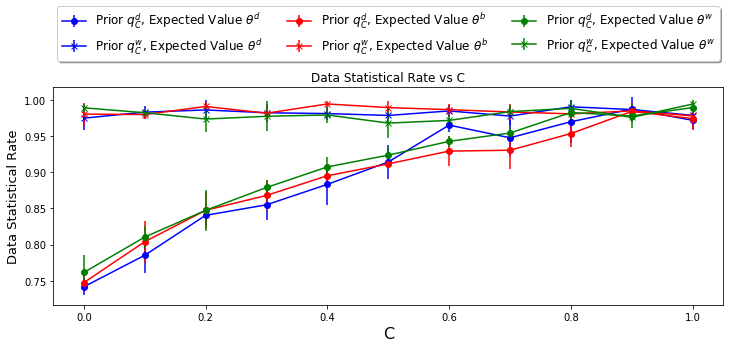

In [36]:
fig = plt.figure(figsize=(12, 4))
cPlot(DIs, "Data Statistical Rate", title="Data Statistical Rate vs C")

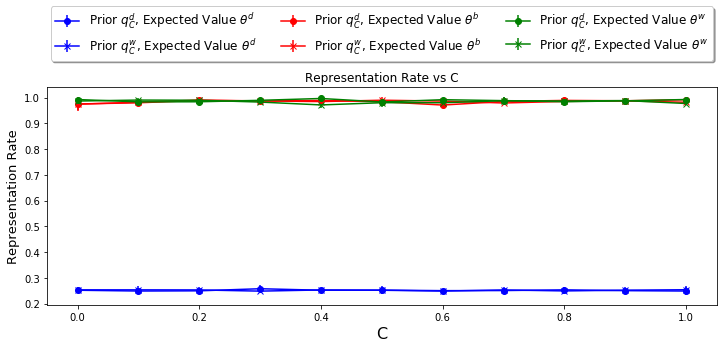

In [37]:
fig = plt.figure(figsize=(12, 4))
cPlot(GRs, "Representation Rate", title="Representation Rate vs C")

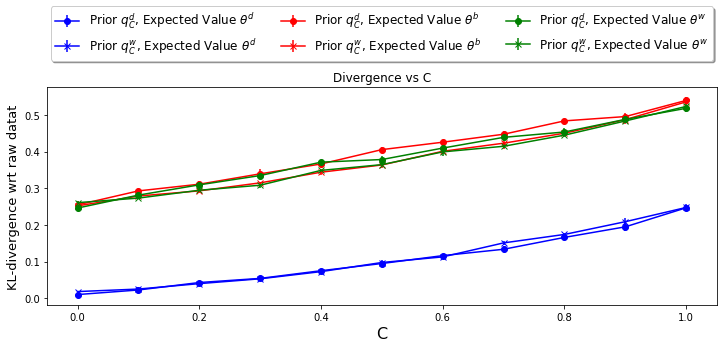

In [38]:
fig = plt.figure(figsize=(12, 4))
cPlot(KLs, "KL-divergence wrt raw datat", title="Divergence vs C")

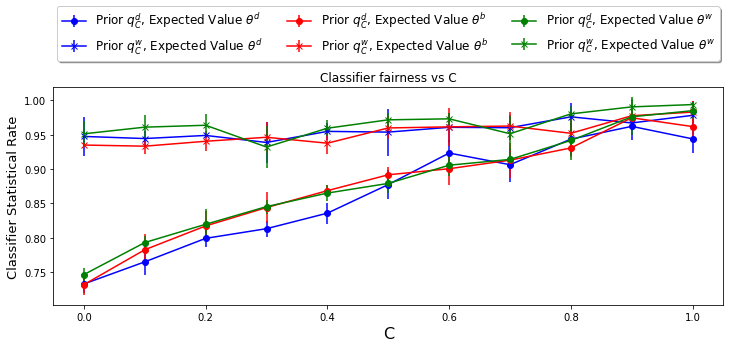

In [39]:
fig = plt.figure(figsize=(12, 4))
cPlot(CDs, "Classifier Statistical Rate", title="Classifier fairness vs C")

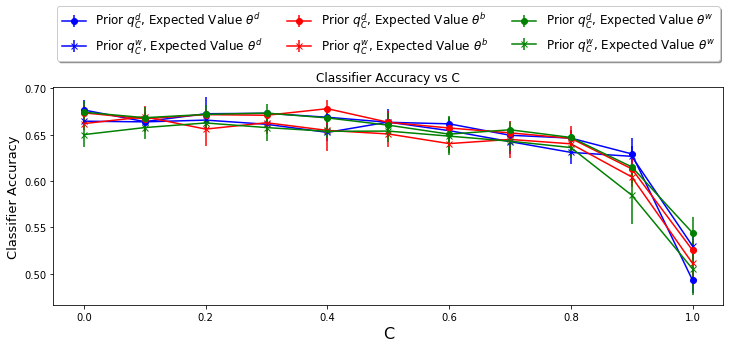

In [40]:
fig = plt.figure(figsize=(12, 4))
cPlot(Accs, "Classifier Accuracy", title="Classifier Accuracy vs C")